In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import numpy as np
import pandas as pd
import squidpy as sq
import os
from sklearn.preprocessing import LabelEncoder
import scprep
from scvi.model import SCVI
import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP, GradModel
from torchcfm.utils import plot_trajectories, torch_wrapper
import pandas as pd
import seaborn as sns
from umap import UMAP
import torch.nn as nn
from torchdyn.core import NeuralODE
import seaborn as sns
from scvi.model import SCVI
import scvi
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance
from sklearn.metrics import r2_score

In [ ]:
scRNA = ad.read_h5ad("data/combined_stereoSeq.h5ad")
print ("Combined data shape: ", scRNA.shape)

sc.pp.normalize_total(scRNA, target_sum=1e4)
sc.pp.log1p(scRNA)
sc.pp.highly_variable_genes(scRNA, flavor="seurat_v3", n_top_genes=2000)
scRNA = scRNA[:, scRNA.var.highly_variable]
sc.pp.scale(scRNA, max_value=10)
sc.tl.pca(scRNA, svd_solver='arpack')
sc.pp.neighbors(scRNA)
sc.tl.umap(scRNA)

In [ ]:
#plot UMAP and PCA
sc.pl.pca(scRNA, color=['Annotation', 'Batch'])
sc.pl.umap(scRNA, color=['Annotation', 'Batch'])

In [44]:
def preprocess_data(scRNA, cell_type_key='Annotation', spatial_key = 'spatial', n_pca=50):

    le = LabelEncoder()
    scRNA.obs[cell_type_key] = le.fit_transform(scRNA.obs[cell_type_key])
    X_input = []
    X_conditional = []
    X_spatial = []

    if (reducer == "UMAP"):
        print ("Using UMAP for input data")
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_umap'])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])
            
    elif (reducer == "PCA"):
        print ("Using PCA for input data")
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_pca'][:, :n_pca])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])

    elif (reducer == "scVI"):
        print ("Using scVI for input data")
        #read the data (again cause scVI requires unormalized data) and set up scVI
        scRNA = ad.read_h5ad("data/combined_stereoSeq.h5ad")
        scvi.model.SCVI.setup_anndata(scRNA)
        model = SCVI(scRNA)
        model.train()
        latent = model.get_latent_representation()
        scRNA.obsm["X_scVI"] = latent
        
        for batch in scRNA.obs['Batch'].unique():
            batch_data = scRNA[scRNA.obs['Batch'] == batch]
            X_input.append(batch_data.obsm['X_scVI'])
            X_conditional.append(batch_data.obs[cell_type_key].values)
            X_spatial.append(batch_data.obsm[spatial_key])
    
    else:
        raise ValueError("Unsupported reducer type. Choose from 'UMAP', 'PCA', or 'scVI'.")

    return X_input, X_conditional, X_spatial

reducer = "scVI"
X_input, _, _ = preprocess_data(scRNA)  
n_times = len(X_input)      

Using scVI for input data


/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python c

Training:   0%|          | 0/278 [00:00<?, ?it/s]

/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/fceccarelli/miniconda3/envs/FM/lib/python3.11/site-packages/scvi/module/_vae.py:573: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/home/fcecca

In [45]:
params= {}  
params['batch_size'] = 256
params['sigma'] = 0.1
params['dim'] = X_input[0].shape[1]
params['learning_rate'] = 1e-4
params['n_epochs'] = 10000
params['out_dim'] = params['dim']
params['w'] = 64
params['time_varying'] = True
params['lambda_'] = 1

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print ("Using device: ", device)
print ("Input shape: ", X_input[0].shape[1])

Using device:  cuda
Input shape:  10


In [46]:
def get_batch(FM, X_input, batch_size, n_times, return_noise=False):
    """Construct a batch with points from each timepoint pair"""

    ts = []
    xts = []
    uts = []
    np.random.seed(42)
    
    for t_start in range(n_times - 1):
        
        b0 = np.random.randint(X_input[t_start].shape[0], size=batch_size)
        b1 = np.random.randint(X_input[t_start+1].shape[0], size=batch_size)
        
        x0 = (torch.from_numpy(X_input[t_start][b0]).float().to(device))
        x1 = (torch.from_numpy(X_input[t_start + 1][b1]).float().to(device))
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1, return_noise=return_noise)
        
        ts.append(t + t_start)
        xts.append(xt)
        uts.append(ut)

    t = torch.cat(ts)
    xt = torch.cat(xts)
    ut = torch.cat(uts)

    return t, xt, ut

Using CUDA:  True


100%|██████████| 10000/10000 [09:22<00:00, 17.77it/s]


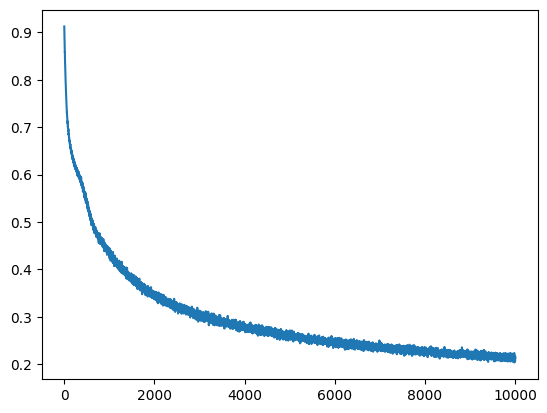

In [47]:
def train(params, n_times, X_input):
    
    use_cuda = torch.cuda.is_available()
    print ("Using CUDA: ", use_cuda)

    batch_size = params['batch_size']

    ot_cfm_model = MLP(dim=params['dim'], out_dim=params['out_dim'], time_varying=params['time_varying'], w=params['w']).to(device)
    ot_cfm_optimizer = torch.optim.Adam(ot_cfm_model.parameters(), params['learning_rate'])
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=params['sigma'])

    losses = []
    for i in tqdm(range(params['n_epochs'])):
        ot_cfm_optimizer.zero_grad()
        t, xt, ut = get_batch(FM, X_input, batch_size, n_times)
        vt = ot_cfm_model(torch.cat([xt, t[:, None]], dim=-1))

        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        losses.append(loss.item())
        ot_cfm_optimizer.step()

    plt.plot(losses)

    return ot_cfm_model

ot_cfm_model= train(params, n_times,  X_input)

In [ ]:
"""
M = lambda_*torch.cdist(x0, x1) ** 2+ (1-lambda_)*torch.cdist(p0, p1)**2
"""

In [48]:
class SimpleODEVectorField(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, args=None):
        # Expand scalar t to match batch size
        if x.dim() > 1:
            t_expanded = t.expand(x.shape[0], 1) if isinstance(t, torch.Tensor) else torch.full((x.shape[0], 1), t, device=x.device, dtype=x.dtype)
        else:
            t_expanded = t.reshape(1, 1) if isinstance(t, torch.Tensor) else torch.tensor([[t]], device=x.device, dtype=x.dtype)

        model_input = torch.cat([x, t_expanded], dim=-1)
        dxdt = self.model(model_input)
        return dxdt

ode_field = SimpleODEVectorField(ot_cfm_model)
node = NeuralODE(ode_field, solver="dopri5", sensitivity="adjoint")

Evaluating: time 0 → 1
t=0 → t+1: MMD=0.0083, Wasserstein=0.0667, Energy=0.0461, R2=-0.3960
Evaluating: time 1 → 2
t=1 → t+1: MMD=0.1343, Wasserstein=0.8535, Energy=0.4703, R2=-3.3026
Evaluating: time 2 → 3
t=2 → t+1: MMD=0.2210, Wasserstein=1.0029, Energy=0.5204, R2=-7.3763
Evaluating: time 3 → 4
t=3 → t+1: MMD=0.1342, Wasserstein=0.9202, Energy=0.5007, R2=-4.9411


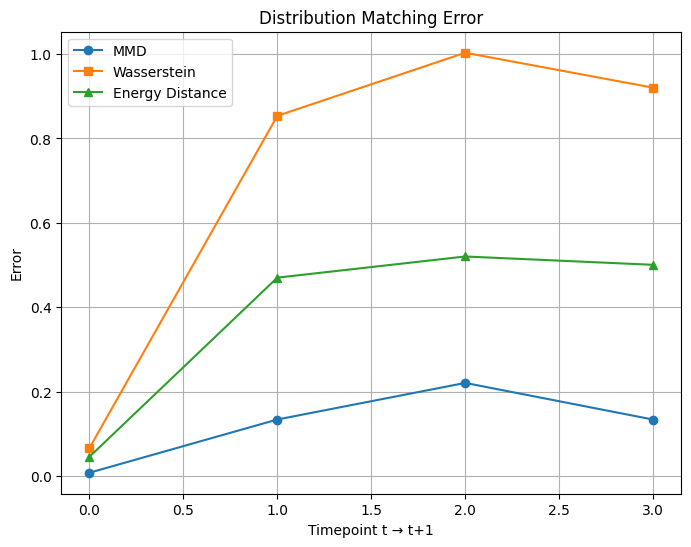

In [49]:
def compute_mmd_multi_rbf(X, Y, gammas=[2, 1, 0.5, 0.1, 0.01, 0.005]):
    """
    Compute multi-kernel MMD^2 between X and Y with multiple RBF gammas.

    X: [N, D]
    Y: [M, D]
    gammas: list of gamma values (1 / (2*sigma^2))

    Returns:
    mean MMD^2 across gammas
    """
    XX = torch.cdist(X, X, p=2)**2
    YY = torch.cdist(Y, Y, p=2)**2
    XY = torch.cdist(X, Y, p=2)**2

    m = X.size(0)
    n = Y.size(0)

    mmd_total = 0.0

    for gamma in gammas:
        K_XX = torch.exp(-gamma * XX)
        K_YY = torch.exp(-gamma * YY)
        K_XY = torch.exp(-gamma * XY)

        mmd2 = (K_XX.sum() - torch.diagonal(K_XX).sum()) / (m * (m - 1)) \
             + (K_YY.sum() - torch.diagonal(K_YY).sum()) / (n * (n - 1)) \
             - 2 * K_XY.mean()

        mmd_total += mmd2

    mean_mmd = mmd_total / len(gammas)
    return mean_mmd.item()

def compute_wasserstein(X, Y):
    # flatten to 1D for each feature or mean across features
    X_flat = X.cpu().numpy().flatten()
    Y_flat = Y.cpu().numpy().flatten()
    return wasserstein_distance(X_flat, Y_flat)

def compute_energy(X, Y):
    X_flat = X.cpu().numpy().flatten()
    Y_flat = Y.cpu().numpy().flatten()
    return energy_distance(X_flat, Y_flat)

def compute_r2(X, Y):
    X_flat = X.cpu().numpy().flatten()
    Y_flat = Y.cpu().numpy().flatten()
    return r2_score(Y_flat, X_flat)


def evaluate(node, X_input, device, steps=400, n_points=5000, plot_distributions=False):
    mmd_list = []
    wasserstein_list = []
    energy_list = []
    r2_list = []

    for t in range(len(X_input) - 1):
        print(f"Evaluating: time {t} → {t+1}")
        
        x0_np = X_input[t]
        x1_np = X_input[t + 1]

        n = min(n_points, min(len(x0_np), len(x1_np)))
        idx = np.random.choice(min(len(x0_np), len(x1_np)), size=n, replace=False)

        x0 = torch.tensor(x0_np[idx]).float().to(device)
        x1_true = torch.tensor(x1_np[idx]).float().to(device)

        t_span = torch.linspace(0, 1, steps).to(device)
        with torch.no_grad():
            traj = node.trajectory(x0, t_span)
        x1_pred = traj[-1]

        mmd_value = compute_mmd_multi_rbf(x1_pred.cpu(), x1_true.cpu())
        wasserstein_value = compute_wasserstein(x1_pred, x1_true)
        energy_value = compute_energy(x1_pred, x1_true)
        r2_value = compute_r2(x1_pred, x1_true)

        mmd_list.append(mmd_value)
        wasserstein_list.append(wasserstein_value)
        energy_list.append(energy_value)
        r2_list.append(r2_value)

        print (f"t={t} → t+1: MMD={mmd_value:.4f}, Wasserstein={wasserstein_value:.4f}, "
               f"Energy={energy_value:.4f}, R2={r2_value:.4f}")

        if plot_distributions:
            plt.figure(figsize=(6,4))
            sns.kdeplot(x1_pred.cpu().numpy().flatten(), label="Predicted", fill=True)
            sns.kdeplot(x1_true.cpu().numpy().flatten(), label="True", fill=True)
            plt.title(f"Distribution at t={t+1}")
            plt.xlabel("Feature value (flattened)")
            plt.legend()
            plt.tight_layout()
            plt.show()

    return mmd_list, wasserstein_list, energy_list, r2_list

mmd_list, wassersten_list, energy_list, r2_list = evaluate(node, X_input, device)

plt.figure(figsize=(8,6))
plt.plot(range(len(mmd_list)), mmd_list, label='MMD', marker='o')
plt.plot(range(len(wassersten_list)), wassersten_list, label='Wasserstein', marker='s')
plt.plot(range(len(energy_list)), energy_list, label='Energy Distance', marker='^')
#plt.plot(range(len(r2_list)), r2_list, label='R2 Score', marker='D')
plt.xlabel("Timepoint t → t+1")
plt.ylabel("Error")
plt.title("Distribution Matching Error")
plt.legend()
plt.grid(True)
plt.show()